# Сборный проект-4

Необходимо разработать демонстрационную версию поиска изображений по запросу.

Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

### Описание данных

Данные доступны по [ссылке](https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip).

В файле `train_dataset.csv` находится информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `train_images` содержатся изображения для тренировки модели.

В файле `CrowdAnnotations.tsv` — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.
3. Доля людей, подтвердивших, что описание соответствует изображению.
4. Количество человек, подтвердивших, что описание соответствует изображению.
5. Количество человек, подтвердивших, что описание не соответствует изображению.

В файле `ExpertAnnotations.tsv` содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.

3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.

В файле `test_queries.csv` находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `test_images` содержатся изображения для тестирования модели.

In [85]:
#!pip install lightgbm

In [86]:
import pandas as pd
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import nltk
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize, pos_tag
from nltk.corpus import stopwords
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from sklearn.model_selection import GroupShuffleSplit
from tqdm.notebook import tqdm
tqdm.pandas()

In [87]:
IMG_SIZE = (500, 304) 
BATCH_SIZE = 16
TEST_DIR = './datasets/test_images/'

## 1. Загрузка данных

In [88]:
train_df = pd.read_csv('./datasets/train_dataset.csv')
test_df = pd.read_csv('./datasets/test_queries.csv', sep='|')
crowdAnnotations = pd.read_csv(
    './datasets/CrowdAnnotations.tsv', 
    sep='\t', 
    header=None, 
    names=['image', 'query_id', 'match_fraction', 'match_count', 'not_match_count']
)
expertAnnotations = pd.read_csv(
    './datasets/ExpertAnnotations.tsv', 
    sep='\t', 
    header=None,
    names=['image', 'query_id', 'exp1', 'exp2', 'exp3']
)

In [89]:
def table_info(pd_df):
    display(pd_df.head())
    pd_df.info()

In [90]:
table_info(train_df)
table_info(test_df)
table_info(crowdAnnotations)
table_info(expertAnnotations)

,image,query_id,query_text
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
3,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
4,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB


,Unnamed: 0,query_id,query_text,image
0,0,1177994172_10d143cb8d.jpg#0,"Two blonde boys , one in a camouflage shirt an...",1177994172_10d143cb8d.jpg
1,1,1177994172_10d143cb8d.jpg#1,Two boys are squirting water guns at each other .,1177994172_10d143cb8d.jpg
2,2,1177994172_10d143cb8d.jpg#2,Two boys spraying each other with water,1177994172_10d143cb8d.jpg
3,3,1177994172_10d143cb8d.jpg#3,Two children wearing jeans squirt water at eac...,1177994172_10d143cb8d.jpg
4,4,1177994172_10d143cb8d.jpg#4,Two young boys are squirting water at each oth...,1177994172_10d143cb8d.jpg


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  500 non-null    int64 
 1   query_id    500 non-null    object
 2   query_text  500 non-null    object
 3   image       500 non-null    object
dtypes: int64(1), object(3)
memory usage: 15.8+ KB


,image,query_id,match_fraction,match_count,not_match_count
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,1.0,3,0
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,0.0,0,3
2,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,0.0,0,3
3,1056338697_4f7d7ce270.jpg,2073964624_52da3a0fc4.jpg#2,0.0,0,3
4,1056338697_4f7d7ce270.jpg,2083434441_a93bc6306b.jpg#2,0.0,0,3


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   image            47830 non-null  object 
 1   query_id         47830 non-null  object 
 2   match_fraction   47830 non-null  float64
 3   match_count      47830 non-null  int64  
 4   not_match_count  47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB


,image,query_id,exp1,exp2,exp3
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,1,2


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image     5822 non-null   object
 1   query_id  5822 non-null   object
 2   exp1      5822 non-null   int64 
 3   exp2      5822 non-null   int64 
 4   exp3      5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.6+ KB


In [91]:
test_df = test_df.drop('Unnamed: 0', axis=1)

In [92]:
train_df[train_df.duplicated()]

,image,query_id,query_text


In [93]:
test_df[test_df.duplicated()]

,query_id,query_text,image


In [94]:
crowdAnnotations[crowdAnnotations.duplicated()]

,image,query_id,match_fraction,match_count,not_match_count


In [95]:
expertAnnotations[expertAnnotations.duplicated()]

,image,query_id,exp1,exp2,exp3


Загружены 4 таблицы. Дубликатов и пропусков в данных не обнаружено. Из тестовых данных удалены лишние столбцы.

## 2. Исследовательский анализ данных

Наш датасет содержит экспертные и краудсорсинговые оценки соответствия текста и изображения.

В файле с экспертными мнениями для каждой пары изображение-текст имеются оценки от трёх специалистов. Для решения задачи эти оценки нужно агрегировать — превратить в одну. В качестве агрегации решено выбрать - голосование большинства: за какую оценку проголосовала большая часть экспертов (в нашем случае 2 или 3), та оценка и ставится как итоговая. Поскольку число экспертов меньше числа классов, может случиться, что каждый эксперт поставит разные оценки, например: 1, 4, 2. В таком случае данную пару изображение-текст можно исключить из датасета.

В файле с краудсорсинговыми оценками информация расположена в таком порядке:

1. Доля исполнителей, подтвердивших, что текст **соответствует** картинке.
2. Количество исполнителей, подтвердивших, что текст **соответствует** картинке.
3. Количество исполнителей, подтвердивших, что текст **не соответствует** картинке.

После анализа экспертных и краудсорсинговых оценок решено объединить их в одну по какому-то критерию: оценка эксперта принимается с коэффициентом 0.6, а крауда — с коэффициентом 0.4.

Целевая переменная должна иметь значения от 0 до 1.


In [96]:
# В каждой строке датасета выбирает ту оценку, котору больше всего экспертов выбрало
def aggExperts(row):
    values = [0, 0, 0, 0]
    values[row['exp1']-1] += 1
    values[row['exp2']-1] += 1
    values[row['exp3']-1] += 1
    maximum = max(values)
    if maximum > 1: # если какую-то оценку поставили больше 1-го раза
        row['aggExperts'] = values.index(maximum) + 1
    return row


In [97]:
expertAnnotations = expertAnnotations.apply(aggExperts, axis=1)
expertAnnotations = expertAnnotations[expertAnnotations['aggExperts'].notna()] # Берем только те строки где удалось агрегировать оценки экспертов
expertAnnotations = expertAnnotations.drop(['exp1', 'exp2', 'exp3'], axis=1)

In [98]:
table_info(expertAnnotations)

,aggExperts,image,query_id
0,1.0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2
1,1.0,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2
2,1.0,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2
3,2.0,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2
4,1.0,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2


<class 'pandas.core.frame.DataFrame'>
Index: 5696 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   aggExperts  5696 non-null   float64
 1   image       5696 non-null   object 
 2   query_id    5696 non-null   object 
dtypes: float64(1), object(2)
memory usage: 178.0+ KB


In [99]:
unitedAnnotations = pd.merge(expertAnnotations, crowdAnnotations, on=['query_id', 'image'], how='left')

In [100]:
table_info(unitedAnnotations)

,aggExperts,image,query_id,match_fraction,match_count,not_match_count
0,1.0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,0.0,0.0,3.0
1,1.0,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,0.0,0.0,3.0
2,1.0,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,NaN,NaN,NaN
3,2.0,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,NaN,NaN,NaN
4,1.0,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5696 entries, 0 to 5695
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   aggExperts       5696 non-null   float64
 1   image            5696 non-null   object 
 2   query_id         5696 non-null   object 
 3   match_fraction   2258 non-null   float64
 4   match_count      2258 non-null   float64
 5   not_match_count  2258 non-null   float64
dtypes: float64(4), object(2)
memory usage: 267.1+ KB


In [101]:
# Объединяет оценки экспертов и крауда в одну общую с коэффициентами 0,6 и 0,4 соответственно
def aggMatch(row):
    expCoef = 0.6 # Коэффициент с которым принимаются оценки экспертов (экспертам доверяем больше)
    crCoef = 0.4 # Коэффициент с которым принимаются оценки крауда
    divider = 2.2 # Делитель равный максимальному значению суммы оценок (с учетом коэффициентов) экспертов и крауда. 
    # Нужен чтобы нормировать значение таргета (т.е. 0 <= таргет <= 1)

    adjustedAgg = row['aggExperts']-1 # т.к. оценка 1 эксперта означает, что фото не соответствует описанию, поэтому необходимо, чтобы в этом случае 
    # оценка вообще не увеличивала значение таргета

    if row['match_fraction'] >= 0:
        row['target'] = (adjustedAgg*expCoef + row['match_fraction']*crCoef)/divider
    else:
        row['target'] = (adjustedAgg)/3 # Там где нет оценок крауда будем полностью полагаться на оценки экспертов
    return row

In [102]:
unitedAnnotations = unitedAnnotations.apply(aggMatch, axis=1)

In [103]:
unitedAnnotations = unitedAnnotations.drop(['aggExperts', 'match_fraction', 'match_count', 'not_match_count'], axis=1)
table_info(unitedAnnotations)

,image,query_id,target
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,0.000000
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,0.000000
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,0.000000
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,0.333333
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,0.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5696 entries, 0 to 5695
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   image     5696 non-null   object 
 1   query_id  5696 non-null   object 
 2   target    5696 non-null   float64
dtypes: float64(1), object(2)
memory usage: 133.6+ KB


На данном этапе произведено объединение оценок экспертов с оценками крауда в одну оценку с коэффициентами 0,6 и 0,4 соответственно. Эта оценка и будет нашим таргетом и принимает значения 0 <= таргет <= 1.

## 3. Проверка данных

Все данные, которые содержат в описание слова, относящиеся к детям до 16 лет нужно удалить.

In [104]:
forbiddenWords = [
    'child', 'children', 'boy', 'boys', 'girl', 'girls', 'baby', 'teen', 'teenager', 'infant', 'suckling', 'babe', 'toddler', 'newborn',
    'preschooler', 'preteen', 'youngster'
]

In [105]:
train_df['query_text'] = train_df['query_text'].str.lower()

In [106]:
train_df = train_df[~train_df['query_text'].str.contains('|'.join(forbiddenWords), regex=True)]
table_info(train_df)

,image,query_id,query_text
22,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,a man sleeps under a blanket on a city street .
23,3187395715_f2940c2b72.jpg,3181701312_70a379ab6e.jpg#2,a man sleeps under a blanket on a city street .
24,463978865_c87c6ca84c.jpg,3181701312_70a379ab6e.jpg#2,a man sleeps under a blanket on a city street .
25,488590040_35a3e96c89.jpg,3181701312_70a379ab6e.jpg#2,a man sleeps under a blanket on a city street .
26,534875358_6ea30d3091.jpg,3181701312_70a379ab6e.jpg#2,a man sleeps under a blanket on a city street .


<class 'pandas.core.frame.DataFrame'>
Index: 4328 entries, 22 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       4328 non-null   object
 1   query_id    4328 non-null   object
 2   query_text  4328 non-null   object
dtypes: object(3)
memory usage: 135.2+ KB


In [107]:
train_df = pd.merge(train_df, unitedAnnotations, on=['query_id', 'image'], how='inner')

In [108]:
table_info(train_df)

,image,query_id,query_text,target
0,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,a man sleeps under a blanket on a city street .,0.000000
1,3187395715_f2940c2b72.jpg,3181701312_70a379ab6e.jpg#2,a man sleeps under a blanket on a city street .,0.333333
2,463978865_c87c6ca84c.jpg,3181701312_70a379ab6e.jpg#2,a man sleeps under a blanket on a city street .,0.272727
3,488590040_35a3e96c89.jpg,3181701312_70a379ab6e.jpg#2,a man sleeps under a blanket on a city street .,0.333333
4,534875358_6ea30d3091.jpg,3181701312_70a379ab6e.jpg#2,a man sleeps under a blanket on a city street .,0.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4237 entries, 0 to 4236
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image       4237 non-null   object 
 1   query_id    4237 non-null   object 
 2   query_text  4237 non-null   object 
 3   target      4237 non-null   float64
dtypes: float64(1), object(3)
memory usage: 132.5+ KB


В соответствии с заданием, были удалены данные потенциально содержащие информацию о детях до 16 лет. Было удалено более 1000 строк данных.

## 4. Векторизация изображений и текста

In [109]:
def create_resnet50_vectorizer():
    # Загружаем ResNet50 без верхних слоев
    base_model = ResNet50(
        weights='imagenet',      # Предобученные веса
        include_top=False,       # Убираем полносвязные слои
        pooling='avg'            # Global Average Pooling
    )
    
    # Создаем модель для извлечения признаков
    feature_extractor = Model(
        inputs=base_model.input, 
        outputs=base_model.output
    )
    
    return feature_extractor

# Создаем векторизатор
resnet_vectorizer = create_resnet50_vectorizer()

def vectorize_image_resnet50(img_path, target_size=IMG_SIZE):

    # Загрузка и предобработка изображения
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Добавляем batch dimension
    img_array = preprocess_input(img_array)        # Препроцессинг для ResNet50
    
    # Извлечение признаков
    features = resnet_vectorizer.predict(img_array, verbose=0)
    
    return features.flatten()  # Преобразуем в 1D вектор


In [110]:
# Создает словарь, где ключ имя файла, значение векторизорованное значение изображения
def imgToVecDic(path, fileNames):
    imgToVecDic = {} # Словарь, где ключ имя файла, значение векторизорованное значение изображения
    for x in os.listdir(path):
        if x in fileNames:
            image_path = path+x
            imgToVecDic[x] = vectorize_image_resnet50(image_path)
    return imgToVecDic

In [111]:
# Функция для чистки текста от символов не являющихся текстом
def clear_text(text):
    pattern = r'[^a-zA-z]'
    return " ".join(re.sub(pattern, ' ', text).split())

In [112]:
nltk.download('punkt_tab')      
nltk.download('wordnet')    
nltk.download('omw-1.4') 
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt_tab to C:\Users\KDFX
[nltk_data]     Modes\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\KDFX
[nltk_data]     Modes\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\KDFX
[nltk_data]     Modes\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\KDFX Modes\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to C:\Users\KDFX
[nltk_data]     Modes\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\KDFX Modes\AppData\Roaming\nltk_dat

In [113]:
# Функция для лемматизация текста
def lemmatizeText(text):
    wordnet = WordNetLemmatizer()

    result = ""

    for token,tag in pos_tag(word_tokenize(clear_text(text))):
        pos=tag[0].lower()
                
        if pos not in ['a', 'r', 'n', 'v']:
            pos='n'
            
        result += " " + wordnet.lemmatize(token,pos)

    return result

In [114]:
# Лемматизирует каждую строку в датасете
def lemmatize(row):
    row['lemm'] = lemmatizeText(row['query_text'])
    return row

In [115]:
# Подготовка данных для обучения: векторизация изображений и описаний, затем их конкатенация в один вектор
def prepData(path, df, imgs):
    imgToVecDicTmp = imgToVecDic(path, imgs)
    
    def imgsToVec(row):
        row['img_vec'] = imgToVecDicTmp[row['image']]

        return row
    
    df = df.progress_apply(imgsToVec, axis=1)
    df = df.progress_apply(lemmatize, axis=1)
    tfidfVectorizer = TfidfVectorizer(stop_words=list(stop_words), ngram_range=(1, 3))
    tf_idf = tfidfVectorizer.fit_transform(df['lemm'].values)
    df['txt_vec'] = tf_idf.toarray().tolist()

    df['group_column'] = df.progress_apply(
        lambda row: np.concatenate([row['img_vec'], row['txt_vec']]), 
        axis=1
    )

    return df, tfidfVectorizer

In [116]:
train_df, tfidfVectorizer = prepData('./datasets/train_images/', train_df, train_df['image'].unique())

  0%|          | 0/4237 [00:00<?, ?it/s]

  0%|          | 0/4237 [00:00<?, ?it/s]

  0%|          | 0/4237 [00:00<?, ?it/s]

In [117]:
train_df = train_df[['group_column', 'target']]
table_info(train_df)

,group_column,target
0,"[0.46098414063453674, 0.1436196267604828, 9.71...",0.000000
1,"[0.18724535405635834, 0.1112891435623169, 0.08...",0.333333
2,"[0.17107424139976501, 0.7543863654136658, 0.12...",0.272727
3,"[0.13320967555046082, 0.749947190284729, 0.072...",0.333333
4,"[0.19752159714698792, 0.203386589884758, 0.0, ...",0.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4237 entries, 0 to 4236
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   group_column  4237 non-null   object 
 1   target        4237 non-null   float64
dtypes: float64(1), object(1)
memory usage: 66.3+ KB


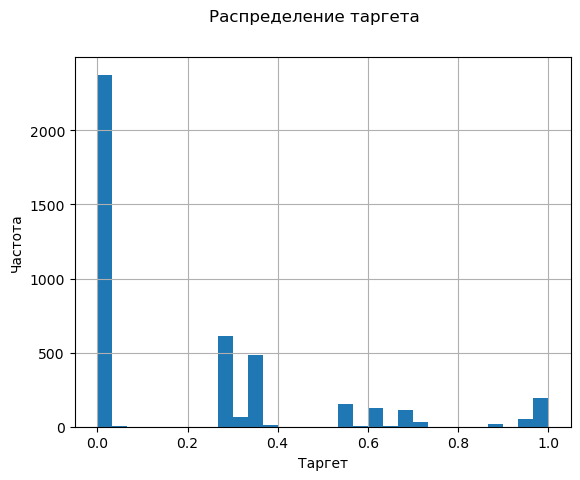

In [118]:
plt.suptitle('Распределение таргета')
target_hist = train_df['target'].hist(bins=30);
target_hist.set_xlabel('Таргет');
target_hist.set_ylabel('Частота');

В данном разделе произведена векторизация изображений с помощью сверточной сети ResNet-50, натренированной на датасете ImageNet. Векторизация текстов описания изображений выполнена методом tf-idf. Затем вектора изображений и соответствуещие вектора описаний были сконкатенированны. Именно эти вектора и будут входными данными для обучения модели. Так же можно заметить, что целевое значение не является непрерывным значением и наиболее частое значение это 0, других значиний значительно меньше, что может сказаться на качестве предсказаний модели.

## 5. Обучение модели предсказания соответствия

In [119]:
X = np.vstack(train_df['group_column'].values)
y = train_df['target'].values

In [120]:
groups = train_df.index.values

gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)
train_indices, test_indices = next(gss.split(X, y, groups=groups))

In [121]:
param_grid_lr = {
    'fit_intercept': [True, False],
    'positive': [True, False]
}

grid_search_lr = GridSearchCV(
    LinearRegression(),
    param_grid_lr,
    cv=5,
    scoring='neg_mean_absolute_error',
    return_train_score=True,
    n_jobs=-1
)

grid_search_lr.fit(X[train_indices], y[train_indices])

best_model_lr = grid_search_lr.best_estimator_
print("Лучшие параметры:", grid_search_lr.best_params_)
print("Лучший MAE:", -grid_search_lr.best_score_)

Лучшие параметры: {'fit_intercept': False, 'positive': True}
Лучший MAE: 0.2058519041284001


In [122]:
lrPred = best_model_lr.predict(X[test_indices])
print("MAE на тестовой выборке", mean_absolute_error(y[test_indices], lrPred))

MAE на тестовой выборке 0.2168853577375272


In [123]:
def trainNet(features_train, target_train, features_test, y_test):
    model = Sequential()

    n_features = features_train.shape[1]
    model.add(Dense(32, input_shape=(n_features,), activation='relu'))
    model.add(Dense(units=16, activation='relu'))
    model.add(Dense(1, activation='relu')  )

    model.compile(loss='mse', optimizer=Adam(0.0001), metrics=['mae'])
    model.summary()
    # Callback для ранней остановки
    early_stopping = EarlyStopping(
        monitor='mae',
        patience=20,
        restore_best_weights=True,
        verbose=1
    )
    model.fit(
        features_train, 
        target_train,
        validation_data=(features_test, y_test), 
        epochs=40, 
        verbose=1,
        steps_per_epoch=1, 
        batch_size=16,
        callbacks=[early_stopping]
    )
    
    return model

In [124]:
net = trainNet(X[train_indices], y[train_indices], X[test_indices], y[test_indices])

c:\pylib\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │       267,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 267,745 (1.02 MB)

 Trainable params: 267,745 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.1704 - mae: 0.2645 - val_loss: 0.1152 - val_mae: 0.2139
Epoch 2/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - loss: 0.1775 - mae: 0.3041 - val_loss: 0.1159 - val_mae: 0.2064
Epoch 3/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 0.1358 - mae: 0.2215 - val_loss: 0.1170 - val_mae: 0.2029
Epoch 4/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - loss: 0.1783 - mae: 0.2649 - val_loss: 0.1177 - val_mae: 0.2018
Epoch 5/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.2126 - mae: 0.2953 - val_loss: 0.1184 - val_mae: 0.2015
Epoch 6/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 0.0672 - mae: 0.1734 - val_loss: 0.1190 - val_mae: 0.2014
Epoch 7/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 0.1332 - mae: 0.2422 - val_loss: 0.1191 - val_mae: 0.2016
Epoch 8/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 0.1408 - mae: 0.1970 - val_loss: 0.1191 - val_mae: 0.2017
Epoch 9/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 0.0917 - mae: 0.1

In [125]:
y_pred = net.predict(X[test_indices]).flatten()
print("MAE на тестовой выборке", mean_absolute_error(y[test_indices], y_pred))

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
MAE на тестовой выборке 0.19890015782053388


In [126]:
param_grid_lgbm = {
    'max_depth': [8, 16, 32, 64, -1],
    'num_leaves': [16, 32, 64, 128],
}

rnd_search_lgbm = GridSearchCV(
    LGBMRegressor(),
    param_grid_lgbm,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)

rnd_search_lgbm.fit(X[train_indices], y[train_indices])

# Лучшая модель
best_model_lgbm = rnd_search_lgbm.best_estimator_
print("Лучшие параметры:", rnd_search_lgbm.best_params_)
print("Лучший MAE:", -rnd_search_lgbm.best_score_)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076329 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 524110
[LightGBM] [Info] Number of data points in the train set: 2965, number of used features: 2334
[LightGBM] [Info] Start training from score 0.207332
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

In [127]:
y_pred = best_model_lgbm.predict(X[test_indices]).flatten()
print("MAE на тестовой выборке", mean_absolute_error(y[test_indices], y_pred))

MAE на тестовой выборке 0.18125674849798898


c:\pylib\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Были обучены 3 модели: LinearRegression, полносвязная нейронная сеть и LGBMRegressor. Лучшие показатели у LGBMRegressor. В качестве метрики была выбрана МАЕ. Метрика для лучшей модели составляет ~ 0.18.

## 6. Тестирование модели

In [128]:
test_df_sample = test_df.sample(10)

In [129]:
imgToVecTestDic = imgToVecDic(TEST_DIR, test_df['image'].unique())

In [130]:
test_df_sample = test_df_sample.apply(lemmatize, axis=1)
tf_idf = tfidfVectorizer.transform(test_df_sample['lemm'])
test_df_sample['txt_vec'] = tf_idf.toarray().tolist()

In [131]:
image_vec_df = pd.DataFrame({'image': imgToVecTestDic.keys(),'img_vec': imgToVecTestDic.values()})

In [132]:
# Находит наиболее релевантное изображение для векторизированного описания изображения
def findImg(df, tf_idf, model):
    df['group_column'] = df.apply(
            lambda row: np.concatenate([row['img_vec'], tf_idf]), 
            axis=1
    )
    X_pred = np.vstack(df['group_column'].values)
    pred = model.predict(X_pred)
    maxMatch = max(pred)
    maxIndex = np.where(pred==maxMatch)[0][0]
    return maxMatch, df.loc[maxIndex, 'image']

In [133]:
def predToDf(row):
    match, image = findImg(image_vec_df, row['txt_vec'], best_model_lgbm)
    row['match'] = match
    row['match_image'] = image
    return row

In [134]:
test_df_sample = test_df_sample.progress_apply(predToDf, axis=1)
test_df_sample

  0%|          | 0/10 [00:00<?, ?it/s]

c:\pylib\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\pylib\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\pylib\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\pylib\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\pylib\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\pylib\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMR

,query_id,query_text,image,lemm,txt_vec,match,match_image
339,3438981089_2ef1a6353c.jpg#4,The man is performing a trick with an orange b...,3438981089_2ef1a6353c.jpg,The man be perform a trick with an orange bic...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.618884,2517284816_9b8fd3c6b6.jpg
206,3036971334_78187a9570.jpg#1,A man is jumping off a rock into a pool of wat...,3036971334_78187a9570.jpg,A man be jump off a rock into a pool of water...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.686475,2517284816_9b8fd3c6b6.jpg
36,1745110280_0cbff5e273.jpg#1,A caramel colored dog sits in front of trees l...,1745110280_0cbff5e273.jpg,A caramel color dog sits in front of tree loo...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.504714,1745110280_0cbff5e273.jpg
216,3044745642_1d0784ff29.jpg#1,Men in a khaki-colored tent outside in a rundo...,3044745642_1d0784ff29.jpg,Men in a khaki color tent outside in a rundow...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.504254,2517284816_9b8fd3c6b6.jpg
355,3466891862_9afde75568.jpg#0,A dog fetching a stick .,3466891862_9afde75568.jpg,A dog fetch a stick,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.543485,3466891862_9afde75568.jpg
315,3396275223_ee080df8b5.jpg#0,A girl is wearing a purple sash and matching s...,3396275223_ee080df8b5.jpg,A girl be wear a purple sash and matching skirt,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.544086,2517284816_9b8fd3c6b6.jpg
197,3030079705_0dee8a3e89.jpg#2,A man lies on a blue blanket with a child on h...,3030079705_0dee8a3e89.jpg,A man lie on a blue blanket with a child on h...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.572685,2517284816_9b8fd3c6b6.jpg
396,3555573680_41c1540a86.jpg#1,A man is doing a jump on a wakeboard in the wa...,3555573680_41c1540a86.jpg,A man be do a jump on a wakeboard in the water,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.663750,2517284816_9b8fd3c6b6.jpg
400,3601978895_9fec23ce0c.jpg#0,a man leans against a large robot .,3601978895_9fec23ce0c.jpg,a man lean against a large robot,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.565057,2517284816_9b8fd3c6b6.jpg
188,2977379863_2e8d7a104e.jpg#3,A group of children dressed for halloween stan...,2977379863_2e8d7a104e.jpg,A group of child dress for halloween stand in...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.500777,2517284816_9b8fd3c6b6.jpg


In [135]:
def display_images(image_paths, descriptions=None, figsize=(15, 10)):

    n_images = len(image_paths)
    n_rows = (n_images + 1) // 2
    
    fig, axes = plt.subplots(n_rows, 2, figsize=figsize)
    axes = axes.flatten() 
    
    for i, (ax, img_path) in enumerate(zip(axes, image_paths)):
        img = Image.open(img_path)
        ax.imshow(img)
        ax.axis('off')  # Убираем оси
            
        # Добавляем описание
        if descriptions is not None and i < len(descriptions):
            description = descriptions[i]
        else:
            description = os.path.basename(img_path)
            
        ax.set_title(description, fontsize=12, pad=20)
    
    # Скрываем пустые subplots
    for j in range(n_images, len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()

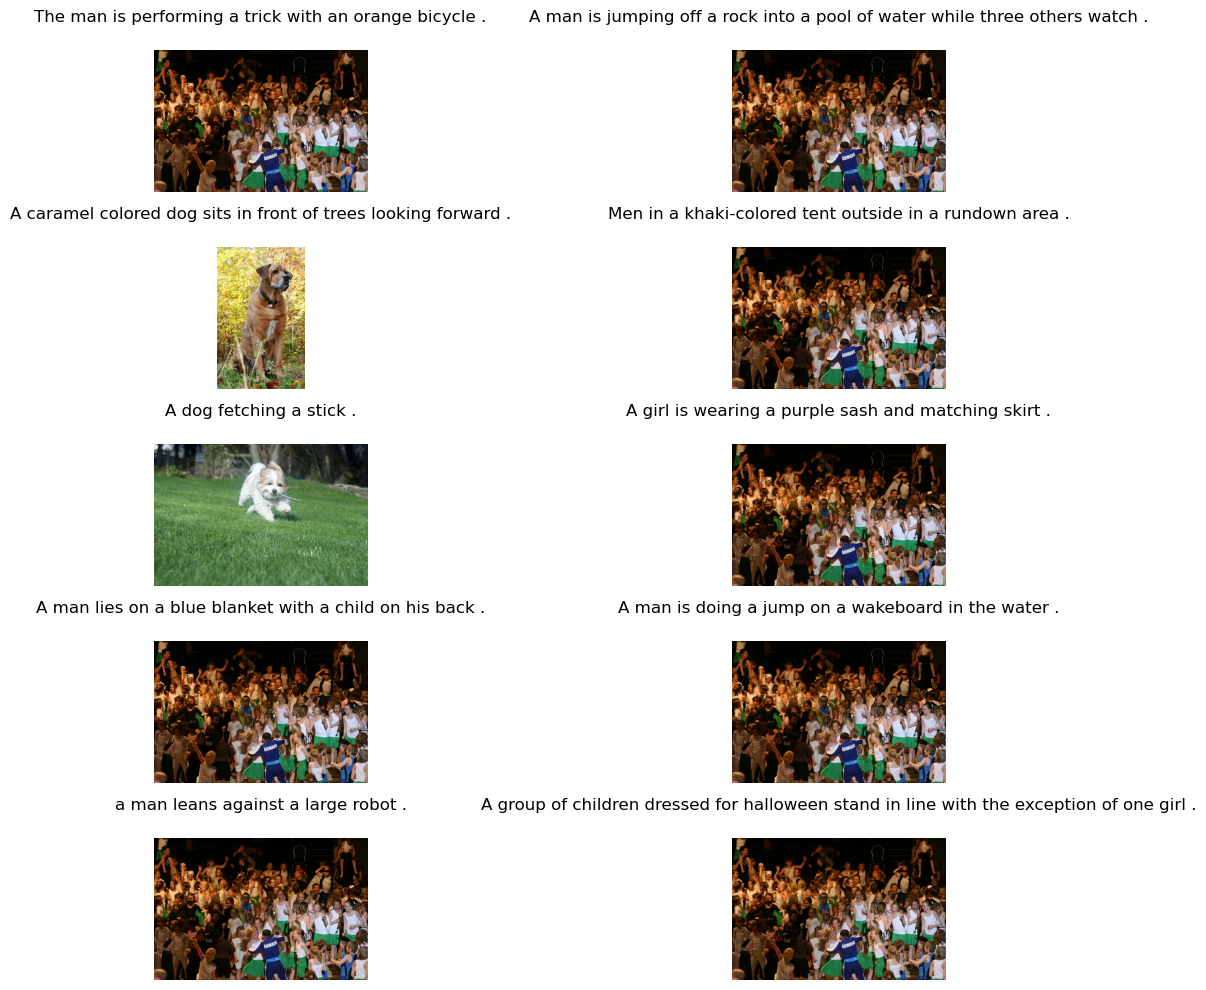

In [136]:
images = []
desc = []
for index, row in test_df_sample.iterrows():
    images.append(TEST_DIR+row['match_image'])
    desc.append(row['query_text'])

display_images(images, desc)

Здесь была протестированна лучшая модель, полученная на предыдущем шаге. Для этого были получены эмбеддинги для всех тестовых изображений из папки `test_images`, выберны случайные 10 запросов из файла `test_queries.csv` и для каждого запроса отображено наиболее релевантное изображение. Как можно видеть, качество предсказаний не очень высокое. Модель чаще находит частично совпадающие с описанием изображения, а не те которые полностью совпадают с описанием. 

## 7. Выводы

В данной работе необходимо было разработать демонстрационную версию поиска изображений по запросу.

Для демонстрационной версии нужно было обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

Для обучения были представлены данные экспертов и крауда, которые оценивали степеть соответствия изображения его описанию. Данные оценки были объединены в одну оценку с коэффициентами 0,6 и 0,4 соответственно. Эта оценка и является таргетом и принимает значения 0 <= таргет <= 1.

В соответсвии с требованиями задания из обучающей выборки были исключены данные, которые могут потенциально содержать информацию о детях до 16 лет.

Для обучения моделей данные были преобразованны следующим образом. Произведена векторизация изображений с помощью сверточной сети ResNet-50, натренированной на датасете ImageNet. Векторизация текстов описания изображений выполнена методом tf-idf. Затем вектора изображений и соответствуещие вектора описаний были сконкатенированны.

Были обучены 3 модели: LinearRegression, полносвязная нейронная сеть и LGBMRegressor. Лучшие показатели у LGBMRegressor. В качестве метрики была выбрана МАЕ. Метрика для лучшей модели составляет ~ 0.18.

Качество предсказаний лучшей модели на тестовой выборке оказалось не очень высокое. Модель чаще находит частично совпадающие с описанием изображения, а не те которые полностью совпадают с описанием. 

В целом проект по созданию сервиса поиска фотографий по текстовому описанию практически осуществим. Но для повышения качества предсказаний потребуется больше разнородных данных для обучения.